In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import os

# mpl.rcParams['text.usetex']=True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    })

In [3]:
def plot3d(x, u, scheme, LAMBDA, save=True):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$u(x,t)$')

    # plot each line on a separate plane
    n_t = len(u)
    for j in range(n_t):
        ax.plot(x, u[j], zs=T_0 + j*dt, zdir='y')

    ax.set_title(f"{scheme.title()} scheme, $\lambda$={LAMBDA}")
    if save:
        plt.savefig(f"hw1q3-{scheme}-{str(LAMBDA)}.pdf", bbox_inches='tight')

In [33]:
A = -1
B = +1
T_0 = 0
T = 7
LAMBDA = 0.75

c = 1
h = 0.1
dt = h*LAMBDA

n_x = int(np.abs(B-A)/h)+2
n_t = int((T - T_0)/dt)+2

x = np.linspace(A, B, n_x)
t = np.linspace(T_0, T, n_t)

In [34]:
# Initial condition
def u_0(x):
    if x <= 0:
        return 1
    elif x >= 1:
        return 0
    else:
        return (2*x**3 - 3*x**2 + 1)

# Exact solution
def f(x,t):
    return u_0(x-c*t)

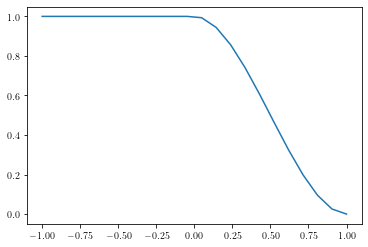

In [35]:
def popIC(f):
    u = np.zeros((n_t, n_x), dtype='d')
    u[0] = [f(i) for i in x]
    return u

u = popIC(u_0)
plt.plot(x,u[0])

# returns n initial values on the interval l to r
# also returns the x
def popIC_b(f, l, r, n):
    xvalues = np.linspace(l,r, n)
    u = [f(x) for x in xvalues]
    return u, xvalues

For the Lax-Friedrich and Lax-Wedroff scheme, we need to add an extra value on the right boundary

In [36]:
def godunov(vn, LAMBDA=LAMBDA):
    # Implicitly setting the left-most value of vnPlusOne to be the same as vn,
    vnPlusOne = np.copy(vn)
    for i in range(1,n_x):
        vnPlusOne[i] = vn[i]*(1-LAMBDA) + LAMBDA*vn[i-1]
    return vnPlusOne

def godunov_trimleft(vn, LAMBDA=LAMBDA):
    n = len(vn)
    vnPlusOne = np.zeros(n-1)
    for i in range(1,n):
        vnPlusOne[i-1] = vn[i]*(1-LAMBDA) + LAMBDA*vn[i-1]
    return vnPlusOne

In [43]:
def laxFriedrich(vn):
    vnPlusOne = np.copy(vn)
    vn = np.append(vn, vn[-1])
    for i in range(1,n_x):
        vnPlusOne[i]   = 0.5*(1 - LAMBDA)*vn[i+1] + 0.5*(1+LAMBDA)*vn[i-1]
    return vnPlusOne

def laxFriedrich_trimleftright(vn):
    n = len(vn)
    vnPlusOne = np.zeros(n-2)
    for i in range(1,n-1):
        vnPlusOne[i-1] = 0.5*( (1 - LAMBDA*c)*vn[i+1] + (1+LAMBDA*c)*vn[i-1] )
    return vnPlusOne

In [38]:
def laxWedroff(vn):
    vnPlusOne = np.copy(vn)
    vn = np.append(vn, vn[-1])
    c1 = 0.5*LAMBDA
    c2 = 2*c1**2
    for i in range(1,n_x):
        vnPlusOne[i] = vn[i]*(1-2*c2) + vn[i+1]*(-c1+c2) + vn[i-1]*(c1+c2)
    return vnPlusOne

def laxWedroff_tlr(vn):
    n = len(vn)
    vnPlusOne = np.zeros(n-2)
    c1 = 0.5*LAMBDA
    c2 = 2*c1**2
    for i in range(1,n-2):
        vnPlusOne[i-1] = vn[i]*(1-2*c2) + vn[i+1]*(-c1+c2) + vn[i-1]*(c1+c2)
    return vnPlusOne

In [44]:
def run(scheme, plot=True, save=False):
    functionSignature = scheme.replace('-', '')
    schemeFunc = eval(functionSignature)
    
    u = np.zeros((n_t, n_x))
    
    if schemeFunc == godunov_trimleft:
        w = np.ones((n_t, n_x+n_t))
        v0, xvalues = popIC_b(u_0, A-n_t*h, B, n_t+n_x)
        w[0] = v0
        u[0] = v0[-n_x:]
        v_previous = v0
        for j in range(1, n_t):
            v = schemeFunc(v_previous, LAMBDA)
            w[j][j:] = v
            # Now this v will be smaller in length
            u[j] = v[-n_x:]
            v_previous = v
        x = xvalues[n_t:]
    
    elif schemeFunc in [laxFriedrich_trimleftright, laxWedroff_tlr]:
        w0, xvalues = popIC_b(u_0, A-n_t*h, B+n_t*h, n_x+2*n_t)
        u[0] = w0[n_t:-n_t]
        # Compute j'th level by providing the j-1'th level
        w_pre = w0
        for j in range(1, n_t):
            w = schemeFunc(w_pre)
            u[j] = w[n_t-j:-n_t+j]
            w_pre = w
        x = xvalues[n_t:-n_t]
   
    else:
        u = popIC(u_0)
        for j in range(1, n_t):
            u[j] = schemeFunc(u[j-1])
        x = np.linspace(A, B, n_x)
   
    # If asked for a plot, then plot
    if plot:
        plot3d(x, u, scheme, LAMBDA, save=save)
    return u,x

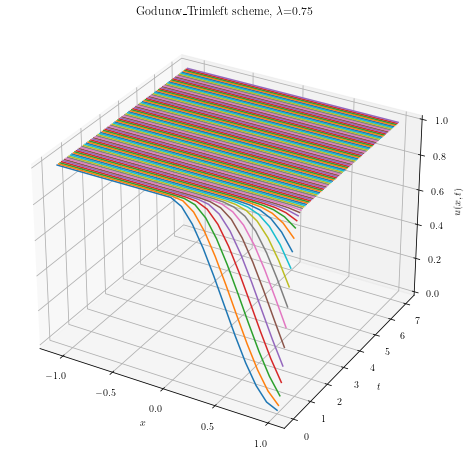

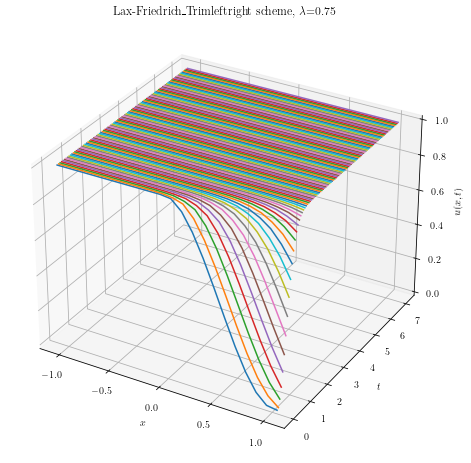

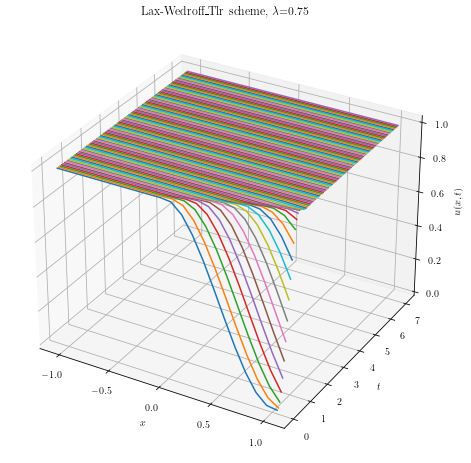

In [46]:
# u_g=run("godunov", save=True)
u_gtl,xgtl=run('godunov_trimleft', save=True)
# u_lf = run("lax-Friedrich", save=True)
u_lftlr,xlftlr = run("lax-Friedrich_trimleftright", save=True)
# u_lw = run("lax-Wedroff", save=False)
u_lwtlr, xlwtlr = run("lax-Wedroff_tlr", save=True)

<Figure size 432x288 with 0 Axes>

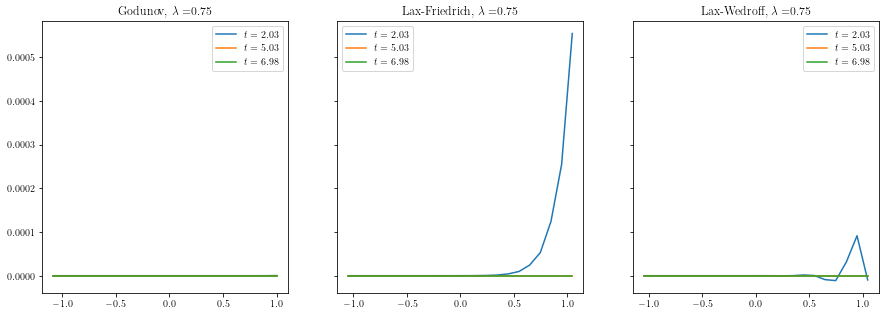

In [47]:
plt.clf()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)
# fig.set_title("Error")
for ax, u, x, title in zip([ax1, ax2, ax3], [u_gtl, u_lftlr, u_lwtlr], [xgtl, xlftlr, xlwtlr], ["Godunov", "Lax-Friedrich", "Lax-Wedroff"]):
    for t in [2,5,7]:
        j = round(t/dt)
        error_array = np.array([f(xi,j*dt) for xi in x]-u[j])
        ax.plot(x,error_array, label=f"$t={round(j*dt, 2)}$")
        ax.set_title(f"{title}, $\lambda=${LAMBDA}")
        ax.legend()
#fig.legend()
fig.savefig(f"hw1q3-error-{LAMBDA}.pdf", bbox_inches='tight')